In [1]:
try:
    spark.stop()
except:
    pass

In [2]:
import torch
print(torch.__version__)

2.5.1


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MovieRecSys").getOrCreate()
print(spark.version)

4.0.0


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)
])
# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, schema = schema).cache()
print(df.count())
# Select first 1000 unique users
unique_users = df.select("userId").distinct().limit(1000)

# Keep only rows from these users
df = df.join(unique_users, on="userId", how="inner")

df.show(5)
print("Rows after limiting:", df.count())
print("Unique users:", df.select("userId").distinct().count())
print("Unique Movies:", df.select("movieId").distinct().count())

32000204
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    28|      1|   4.0|
|    28|      2|   3.0|
|    28|      3|   4.0|
|    28|      5|   2.0|
|    28|      6|   3.0|
+------+-------+------+
only showing top 5 rows
Rows after limiting: 154972
Unique users: 1000
Unique Movies: 11459


In [5]:
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

user_indexer = StringIndexer(inputCol="userId", outputCol="user")
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")

pipeline = Pipeline(stages=[user_indexer, movie_indexer, assembler, scaler])

pipeline_model = pipeline.fit(df)
scaled_df = pipeline_model.transform(df)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final = df_final.cache()
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
| 0.0| 11.0|          0.8|
| 0.0|157.0|          0.6|
| 0.0|456.0|          0.8|
| 0.0|389.0|          0.3|
| 0.0|139.0|          0.6|
+----+-----+-------------+
only showing top 5 rows


In [6]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [7]:
import torch

# 80% train, 20% test
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

#Converting PySpark DF to Pandas to Tensors
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

X_train = torch.tensor(train_pd[["user", "movie"]].values)
y_train = torch.tensor(train_pd["rating_scaled"].values)

X_test = torch.tensor(test_pd[["user", "movie"]].values)
y_test = torch.tensor(test_pd["rating_scaled"].values)

print("Train count:", X_train.shape[0])
print("Train Label:",y_train.shape[0])
print("Test count:", X_test.shape[0])
print("Test Label:",y_test.shape[0])

Train count: 123827
Train Label: 123827
Test count: 31145
Test Label: 31145


In [8]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#print(train_dataset[2200])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  
        self.dropout_emb = 0.4

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden), 
            nn.BatchNorm1d(hidden),  
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),  
            nn.Sigmoid()  
        )

    def forward(self,user,movie):
        u = F.dropout(self.user_emb(user), p=self.dropout_emb, training=self.training)
        m = F.dropout(self.movie_emb(movie), p=self.dropout_emb, training=self.training)
        
        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)
        
        # Pass through MLP
        return self.mlp(x).squeeze()

n_users = df_final.select("user").distinct().count()
n_movies = df_final.select("movie").distinct().count()



In [10]:
loss_fn = nn.MSELoss() # regression on ratings
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-5)


In [11]:
def adam(parameter, m_state, v_state, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state


In [12]:
import copy
all_base = []  # list to store per-epoch stats for BASE

model = CollabFiltering(n_users, n_movies, emb_dim=16, hidden=16, dropout=0.1)
m_state, v_state, t = {}, {}, 0
n_epochs = 10

best_rmse = float("inf")
best_epoch = -1
best_state = None

train_losses_epoch, test_losses_epoch = [], []
train_rmses_epoch, test_rmses_epoch = [], []
epoch_states = []

for epoch in range(n_epochs):
    # ---------- Training ----------
    model.train()
    total_loss, total_sq_error, total_samples = 0,0,0
    for X_batch, y_batch in train_loader:
        preds = model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
        loss = loss_fn(preds, y_batch.float())
        model.zero_grad()
        loss.backward()
        t += 1
        m_state, v_state = adam(model.parameters(), m_state, v_state, t)
        total_loss += loss.item()
        total_sq_error += torch.sum((preds - y_batch)**2).item()
        total_samples += len(y_batch)
    train_loss = total_loss / len(train_loader)
    train_rmse = (total_sq_error / total_samples)**0.5

    # ---------- Testing ----------
    model.eval()
    total_loss, total_sq_error, total_samples = 0,0,0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch[:,0].long(), X_batch[:,1].long()).squeeze()
            loss = loss_fn(preds, y_batch.float())
            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch)**2).item()
            total_samples += len(y_batch)
    test_loss = total_loss / len(test_loader)
    test_rmse = (total_sq_error / total_samples)**0.5

    # ---------- Save per-epoch stats ----------
    train_losses_epoch.append(train_loss)
    test_losses_epoch.append(test_loss)
    train_rmses_epoch.append(train_rmse)
    test_rmses_epoch.append(test_rmse)
    epoch_states.append(copy.deepcopy(model.state_dict()))

    # ---------- Print like your example ----------
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
    print(f"Test  Loss: {test_loss:.4f}, Test  RMSE: {test_rmse:.4f}")

    # ---------- Check best ----------
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_epoch = epoch+1
        best_state = copy.deepcopy(model.state_dict())


all_base.append({
    "id": 1,
    "train_losses": train_losses_epoch,
    "test_losses": test_losses_epoch,
    "train_rmses": train_rmses_epoch,
    "test_rmses": test_rmses_epoch,
    "epoch_states": epoch_states,
    "best_epoch": best_epoch,
    "best_rmse": best_rmse
})

model.load_state_dict(best_state)



Epoch 1/10
Train Loss: 0.0501, Train RMSE: 0.2238
Test  Loss: 0.0434, Test  RMSE: 0.2083

Epoch 2/10
Train Loss: 0.0433, Train RMSE: 0.2080
Test  Loss: 0.0412, Test  RMSE: 0.2029

Epoch 3/10
Train Loss: 0.0410, Train RMSE: 0.2024
Test  Loss: 0.0405, Test  RMSE: 0.2012

Epoch 4/10
Train Loss: 0.0396, Train RMSE: 0.1990
Test  Loss: 0.0400, Test  RMSE: 0.2000

Epoch 5/10
Train Loss: 0.0388, Train RMSE: 0.1969
Test  Loss: 0.0397, Test  RMSE: 0.1992

Epoch 6/10
Train Loss: 0.0382, Train RMSE: 0.1956
Test  Loss: 0.0396, Test  RMSE: 0.1989

Epoch 7/10
Train Loss: 0.0378, Train RMSE: 0.1944
Test  Loss: 0.0395, Test  RMSE: 0.1986

Epoch 8/10
Train Loss: 0.0373, Train RMSE: 0.1931
Test  Loss: 0.0394, Test  RMSE: 0.1983

Epoch 9/10
Train Loss: 0.0371, Train RMSE: 0.1927
Test  Loss: 0.0396, Test  RMSE: 0.1989

Epoch 10/10
Train Loss: 0.0368, Train RMSE: 0.1919
Test  Loss: 0.0394, Test  RMSE: 0.1984


<All keys matched successfully>

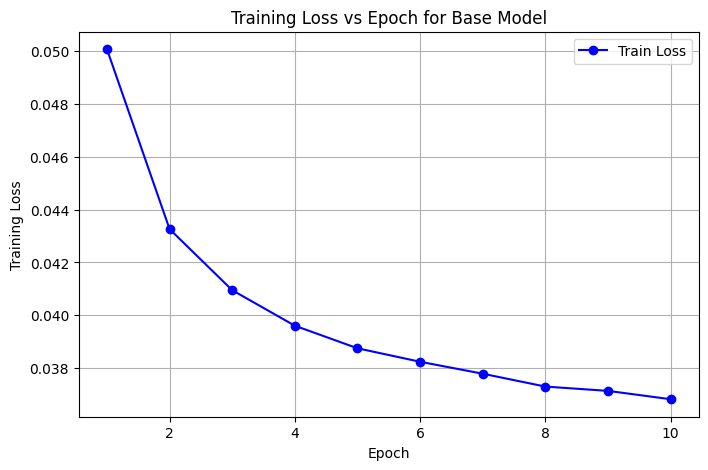

In [13]:
import matplotlib.pyplot as plt

# Extract train losses
train_losses = all_base[0]["train_losses"]
n_epochs = len(train_losses)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), train_losses, marker='o', color='blue', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch for Base Model")
plt.grid(True)
plt.legend()
plt.show()


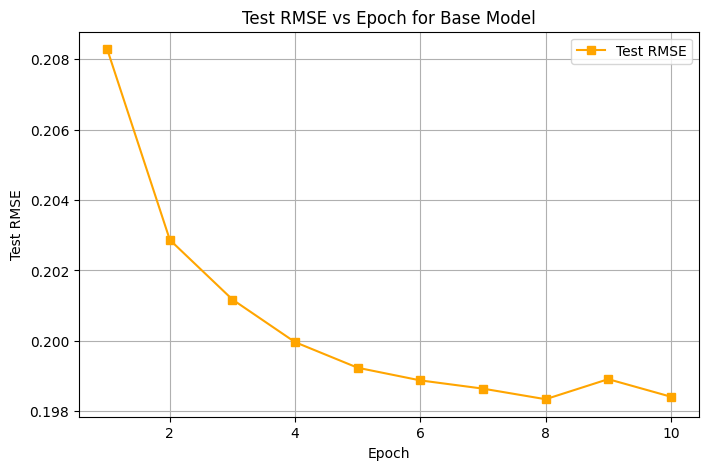

In [14]:
import matplotlib.pyplot as plt

# Extract test RMSE
test_rmses = all_base[0]["test_rmses"]

# Plot Test RMSE
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), test_rmses, marker='s', color='orange', label="Test RMSE")
plt.xlabel("Epoch")
plt.ylabel("Test RMSE")
plt.title("Test RMSE vs Epoch for Base Model")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
import utils

# Prepare dictionary with aggregated curves
metrics = {
    "train_losses": all_base[0]["train_losses"],
    "test_rmses": all_base[0]["test_rmses"]
}

# Save to a pickle file
utils.save_results("results/base_approach.pkl", metrics)
